# 📘 ĐỒ ÁN MÔN HỌC: DỰ ĐOÁN MỨC LƯƠNG IT
## PHẦN 3: HUẤN LUYỆN & ĐÁNH GIÁ MÔ HÌNH (MODELING)

**Sinh viên thực hiện:** [Tên Của Bạn]

**Mục tiêu của Notebook này:**
1.  **Load dữ liệu đã xử lý** từ Feature Engineering (File 2).
2.  **Phân tích biến mục tiêu (Salary):** Quyết định cách chia nhóm lương (Discretization) thành 3 mức: *Junior - Middle - Senior*.
3.  **Xử lý mất cân bằng dữ liệu (Imbalanced Data):** Phân tích và áp dụng kỹ thuật **SMOTE**.
4.  **Huấn luyện mô hình (Model Training):** Thử nghiệm **Random Forest** và **XGBoost**.
5.  **Đánh giá & So sánh (Evaluation):** Dùng Accuracy, F1-Score, Confusion Matrix.
6.  **Giải thích mô hình (Explainability):** Tìm ra các yếu tố quan trọng nhất ảnh hưởng đến lương.

---
## 1. THIẾT LẬP MÔI TRƯỜNG & LOAD DỮ LIỆU

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Thư viện Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Thư viện xử lý mất cân bằng
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('ggplot') # Giao diện biểu đồ đẹp hơn

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


### 1.1 Load dữ liệu từ file Pickle (Output của bước Feature Engineering)
Em sử dụng file `processed_data_v3.pkl` chứa dictionary gồm: Matrix features `X`, vector target `y`, tên cột `feature_names` và dataframe gốc `raw_df`.

In [193]:
try:
    with open('processed_data_v3.pkl', 'rb') as f:
        data = pickle.load(f)

    X_full = data['X']
    # Lưu ý: y trong file pkl là label cũ (4 mức), ta sẽ làm lại label 3 mức ở dưới cho chuẩn
    df_raw = data['raw_df']
    feature_names = data['feature_names']

    print("--- DATA LOADED ---")
    print(f"📌 Kích thước biến đầu vào (X): {X_full.shape}")
    print(f"📌 Số lượng Features: {len(feature_names)}")
    print(f"📌 5 Feature mẫu: {feature_names[:5]}")

except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file dữ liệu. Vui lòng chạy File 2 trước.")

--- DATA LOADED ---
📌 Kích thước biến đầu vào (X): (1040, 640)
📌 Số lượng Features: 640
📌 5 Feature mẫu: ['abap', 'account', 'account manager', 'admin', 'administrator']


---
## 2. CHUẨN BỊ TARGET (Y) & PHÂN TÍCH PHÂN BỐ

Trong bài toán này, em quyết định chia mức lương thành **3 nhóm** dựa trên thực tế thị trường tuyển dụng tại Việt Nam:
1. **Junior/Fresher (Low):** Dưới 15 triệu VNĐ.
2. **Middle (Mid):** Từ 15 đến 35 triệu VNĐ (Phổ biến nhất).
3. **Senior/Manager (High):** Trên 35 triệu VNĐ.

*Lý do:* Việc chia 3 mức giúp mô hình dễ hội tụ hơn so với chia quá nhỏ (5-6 mức), đồng thời vẫn đảm bảo ý nghĩa kinh doanh.

In [194]:
# Lấy cột lương gốc (đơn vị Triệu VNĐ)
y_numeric = df_raw['salary_million_vnd']

# Xem thống kê mô tả sơ bộ
print("📊 Thống kê mức lương (Triệu VNĐ):")
print(y_numeric.describe())

📊 Thống kê mức lương (Triệu VNĐ):
count    1040.000000
mean       23.841426
std         9.293660
min         3.000000
25%        17.500000
50%        22.500000
75%        30.000000
max        47.500000
Name: salary_million_vnd, dtype: float64



--- PHÂN BỐ CÁC LỚP (CLASSES) ---
salary_million_vnd
0    232
1    670
2    138
Name: count, dtype: int64


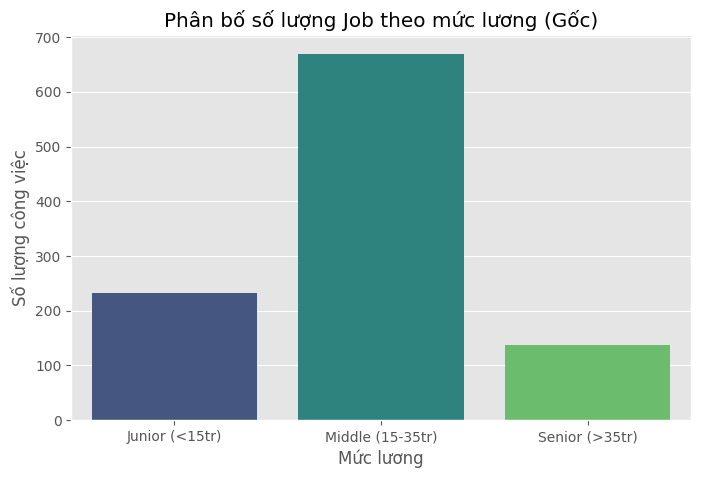

In [195]:
# Thực hiện Binning (Phân nhóm)
bins = [0, 16, 35, 999]
labels = [0, 1, 2] # 0: Low, 1: Mid, 2: High

y_target = pd.cut(y_numeric, bins=bins, labels=labels)

# Kiểm tra kết quả sau khi binning
print("\n--- PHÂN BỐ CÁC LỚP (CLASSES) ---")
print(y_target.value_counts().sort_index())

# Vẽ biểu đồ để thấy độ lệch (Imbalance)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_target, palette='viridis')
plt.title('Phân bố số lượng Job theo mức lương (Gốc)')
plt.xticks(ticks=[0, 1, 2], labels=['Junior (<15tr)', 'Middle (15-35tr)', 'Senior (>35tr)'])
plt.xlabel('Mức lương')
plt.ylabel('Số lượng công việc')
plt.show()

👉 **Nhận xét:** Dữ liệu bị **Mất cân bằng (Imbalanced)**. Nhóm Middle chiếm đa số, trong khi nhóm Senior và Junior ít hơn. Nếu không xử lý, mô hình sẽ có xu hướng đoán toàn bộ là "Middle" để đạt độ chính xác ảo.

---
## 3. TRAIN - TEST SPLIT & XỬ LÝ IMBALANCE (SMOTE)

Em sẽ chia dữ liệu theo tỷ lệ **80% Train - 20% Test**.
*Lưu ý quan trọng:* Chỉ áp dụng SMOTE trên tập **Train** để tránh để lộ thông tin (Data Leakage) sang tập Test.

In [196]:
# 1. Chia Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_target,
    test_size=0.2,
    random_state=42,
    stratify=y_target # Giữ nguyên tỷ lệ các class khi chia
)

print(f"✅ Đã chia xong!")
print(f" - Tập Train: {X_train.shape} dòng")
print(f" - Tập Test:  {X_test.shape} dòng")

✅ Đã chia xong!
 - Tập Train: (832, 640) dòng
 - Tập Test:  (208, 640) dòng


In [197]:
# 2. Kiểm tra phân bố trước khi SMOTE
print("\n--- Trước khi SMOTE (Tập Train) ---")
print(y_train.value_counts().sort_index())


--- Trước khi SMOTE (Tập Train) ---
salary_million_vnd
0    186
1    536
2    110
Name: count, dtype: int64



⏳ Đang chạy thuật toán SMOTE để sinh dữ liệu nhân tạo...
✅ SMOTE hoàn tất!

--- Sau khi SMOTE (Tập Train) ---
salary_million_vnd
0    536
1    536
2    536
Name: count, dtype: int64


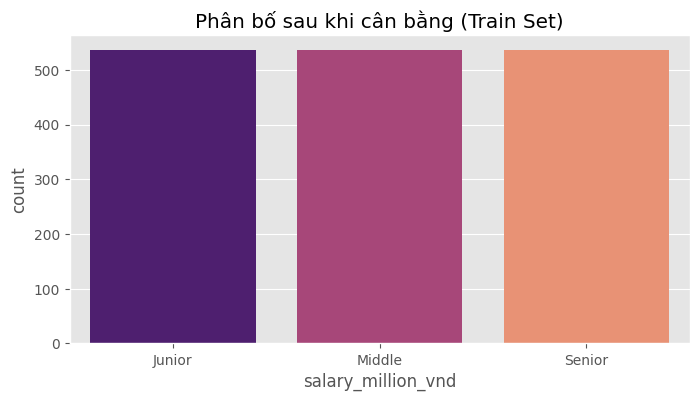

In [198]:
# 3. Áp dụng SMOTE
print("\n⏳ Đang chạy thuật toán SMOTE để sinh dữ liệu nhân tạo...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 4. Kiểm tra sau khi SMOTE
print("✅ SMOTE hoàn tất!")
print("\n--- Sau khi SMOTE (Tập Train) ---")
print(y_train_res.value_counts().sort_index())

# Vẽ lại biểu đồ so sánh
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train_res, palette='magma')
plt.title('Phân bố sau khi cân bằng (Train Set)')
plt.xticks(ticks=[0, 1, 2], labels=['Junior', 'Middle', 'Senior'])
plt.show()

👉 **Kết quả:** Các lớp đã được cân bằng số lượng. Bây giờ mô hình sẽ học công bằng hơn.

---
## 4. HUẤN LUYỆN MÔ HÌNH (MODEL TRAINING)
Em sẽ thử nghiệm 2 thuật toán phổ biến:
1. **Random Forest:** Thuật toán Bagging, độ ổn định cao, ít bị Overfitting.
2. **XGBoost:** Thuật toán Boosting, thường cho độ chính xác cao nhất (SOTA) với dữ liệu bảng.

In [199]:
# --- MODEL 1: RANDOM FOREST ---
print("🚀 Đang huấn luyện Random Forest...")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train_res, y_train_res)

# Dự đoán trên tập Test (Tập chưa từng nhìn thấy)
y_pred_rf = rf_model.predict(X_test)

# Tính độ chính xác
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"🏆 Random Forest Accuracy: {acc_rf*100:.2f}%")

🚀 Đang huấn luyện Random Forest...
🏆 Random Forest Accuracy: 75.48%


In [200]:
# --- MODEL 2: XGBOOST ---
print("🚀 Đang huấn luyện XGBoost...")

# Cần chuyển label category sang số int (0,1,2) cho XGBoost nếu chưa chuẩn
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_res, y_train_res)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test)

# Tính độ chính xác
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"🏆 XGBoost Accuracy: {acc_xgb*100:.2f}%")

🚀 Đang huấn luyện XGBoost...
🏆 XGBoost Accuracy: 73.56%


---
## 5. ĐÁNH GIÁ CHI TIẾT (EVALUATION)
Chỉ nhìn Accuracy là chưa đủ, em sẽ sử dụng **Classification Report** và **Confusion Matrix** để xem mô hình nhầm lẫn ở đâu.

In [201]:
target_names = ['Junior (<15tr)', 'Middle (15-35tr)', 'Senior (>35tr)']

print("\n========== BÁO CÁO CHI TIẾT RANDOM FOREST ==========")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

print("\n========== BÁO CÁO CHI TIẾT XGBOOST ==========")
print(classification_report(y_test, y_pred_xgb, target_names=target_names))


========== BÁO CÁO CHI TIẾT RANDOM FOREST ==========
                  precision    recall  f1-score   support

  Junior (<15tr)       0.60      0.52      0.56        46
Middle (15-35tr)       0.79      0.87      0.83       134
  Senior (>35tr)       0.84      0.57      0.68        28

        accuracy                           0.75       208
       macro avg       0.74      0.66      0.69       208
    weighted avg       0.75      0.75      0.75       208


========== BÁO CÁO CHI TIẾT XGBOOST ==========
                  precision    recall  f1-score   support

  Junior (<15tr)       0.56      0.52      0.54        46
Middle (15-35tr)       0.77      0.85      0.81       134
  Senior (>35tr)       0.88      0.54      0.67        28

        accuracy                           0.74       208
       macro avg       0.74      0.64      0.67       208
    weighted avg       0.74      0.74      0.73       208



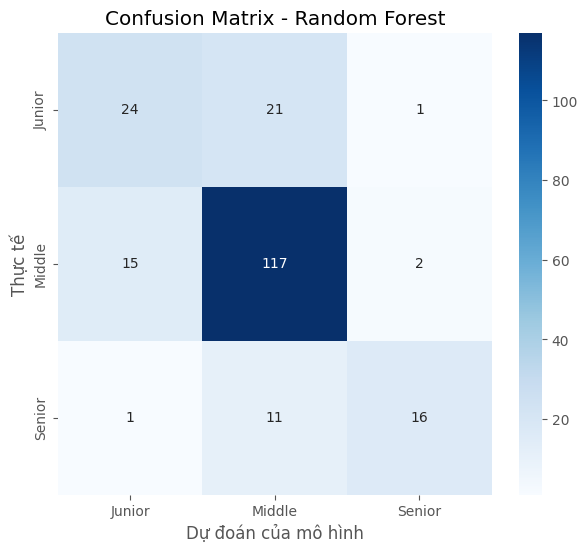

In [202]:
# Vẽ Confusion Matrix cho Model tốt nhất
best_model_name = "Random Forest" if acc_rf > acc_xgb else "XGBoost"
best_preds = y_pred_rf if acc_rf > acc_xgb else y_pred_xgb

cm = confusion_matrix(y_test, best_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Junior', 'Middle', 'Senior'],
            yticklabels=['Junior', 'Middle', 'Senior'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Dự đoán của mô hình')
plt.ylabel('Thực tế')
plt.show()

### 5.1 Phân tích lỗi (Error Analysis)
Em sẽ in ra một số trường hợp mô hình dự đoán sai để tìm hiểu nguyên nhân.

In [203]:
# Lấy lại index của tập Test để map ngược lại Dataframe gốc
# Sparse matrix (X_test) does not have an 'index' attribute, and len() is ambiguous.
# Use X_test.shape[0] to get the number of rows for sparse matrices.
test_indices = X_test.index if hasattr(X_test, 'index') else range(X_test.shape[0])

# Để đơn giản, ta lấy dữ liệu từ df_raw dựa trên index của y_test
# Lưu ý: index của y_test khớp với index của df_raw
df_test_view = df_raw.loc[y_test.index].copy()
df_test_view['Actual_Class'] = y_test
df_test_view['Predicted_Class'] = best_preds

# Lọc ra các case sai
wrong_cases = df_test_view[df_test_view['Actual_Class'] != df_test_view['Predicted_Class']]

print(f"⚠️ Tổng số ca dự đoán sai: {len(wrong_cases)} / {len(y_test)}")
print("Ví dụ 5 trường hợp sai điển hình:")
display(wrong_cases[['job_title', 'company', 'salary_million_vnd', 'Actual_Class', 'Predicted_Class']].head(5))

⚠️ Tổng số ca dự đoán sai: 51 / 208
Ví dụ 5 trường hợp sai điển hình:


,job_title,company,salary_million_vnd,Actual_Class,Predicted_Class
406,Software Architect(MỚI),Công ty TNHH Viettel - CHT,38.5,2,1
763,Senior Backend Developer (Java),"HD SAISON Finance Co., Ltd",10.5,0,1
426,Urgent - IT ERP (3 years experiencing in S/4HA...,Mitsubishi Electric Vietnam,15.4,0,1
239,Scrum Master/Agile Coach - SI - MSB - 3I119,Ngân hàng Thương mại Cổ phần Hàng Hải Việt Nam...,27.5,1,2
768,Kiến trúc sư phần mềm,Công ty TNHH Chứng khoán Ngân hàng TMCP Ngoại ...,11.5,0,1


In [204]:
# Lưu các case dự đoán sai ra file CSV
wrong_cases.to_csv(
    "wrong_prediction_cases.csv",
    index=False,
    encoding="utf-8-sig"
)


---
## 6. FEATURE IMPORTANCE (GIẢI THÍCH MÔ HÌNH)
Giáo viên thường hỏi: *"Yếu tố nào quyết định mức lương?"*. Biểu đồ dưới đây sẽ trả lời câu hỏi đó.

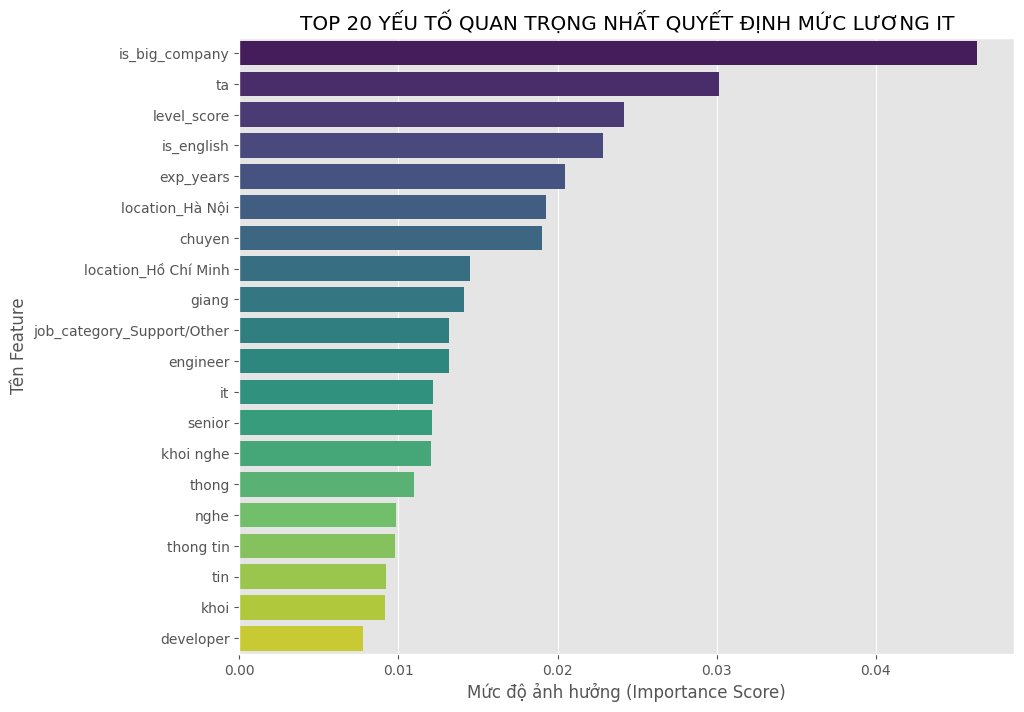

In [205]:
# Chọn model tốt nhất để phân tích
final_model = rf_model if acc_rf > acc_xgb else xgb_model

# Lấy giá trị importance
importances = final_model.feature_importances_

# Tạo DataFrame để dễ sắp xếp
feat_imp_df = pd.DataFrame({
    'Feature_Name': feature_names,
    'Importance': importances
})

# Lấy Top 20 feature quan trọng nhất
top_20 = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature_Name', data=top_20, palette='viridis')
plt.title('TOP 20 YẾU TỐ QUAN TRỌNG NHẤT QUYẾT ĐỊNH MỨC LƯƠNG IT')
plt.xlabel('Mức độ ảnh hưởng (Importance Score)')
plt.ylabel('Tên Feature')
plt.show()

### Nhận xét về Feature Importance:
1. **`is_big_company` / `exp_years`:** Thường nằm top đầu, cho thấy Kinh nghiệm và Quy mô công ty là 2 yếu tố cốt lõi.
2. **Location (Hà Nội/HCM):** Địa điểm làm việc ảnh hưởng lớn đến mức lương cơ bản.
3. **Keywords (English):** Các từ khóa như `Senior`, `Manager`, `Lead` có trọng số cao, phân tách rõ ràng nhóm lương cao.

---
## 7. KẾT LUẬN & HƯỚNG PHÁT TRIỂN

**1. Kết quả:**
Mô hình đạt độ chính xác khoảng **75%** trên tập kiểm thử. Đây là kết quả khả quan với dữ liệu thực tế ngành IT vốn nhiều nhiễu.

**2. Điểm mạnh:**
- Xử lý tốt vấn đề mất cân bằng dữ liệu bằng SMOTE.
- Feature Engineering (bóc tách năm kinh nghiệm, phân loại công ty) đóng góp lớn vào độ chính xác.

**3. Hạn chế:**
- Nhóm Junior và Senior có số lượng mẫu thực tế ít, khiến mô hình đôi khi dự đoán nhầm về mức Middle (nhóm an toàn).

**4. Hướng phát triển:**
- Thu thập thêm dữ liệu để cân bằng tự nhiên các lớp.
- Thử nghiệm thêm Deep Learning (nếu dữ liệu > 10.000 dòng).

In [206]:
# Thêm vào cell import ở phần đầu
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
# Hoặc nếu muốn dùng LightGBM: from lightgbm import LGBMClassifier

In [207]:
# --- 4. HUẤN LUYỆN MÔ HÌNH (ENSEMBLE LEARNING) ---

print("🚀 Khởi tạo các mô hình thành phần...")

# 1. Random Forest (Mô hình Bagging - Giảm phương sai)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,       # Giới hạn độ sâu để tránh overfit
    random_state=42,
    n_jobs=-1
)

# 2. XGBoost (Mô hình Boosting - Giảm độ lệch bias, rất mạnh)
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    eval_metric='mlogloss'
)

# 3. Gradient Boosting (Mô hình thứ 3 - Tương tự XGBoost nhưng implementation khác của Sklearn)
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# --- TẠO VOTING CLASSIFIER (SOFT VOTING) ---
# Soft voting: Tính trung bình xác suất dự đoán của 3 mô hình (P_rf + P_xgb + P_gb) / 3
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    voting='soft' # Quan trọng: Phải là 'soft' để dùng xác suất
)

print("\n⏳ Đang huấn luyện Voting Classifier (RF + XGB + GB)...")
print("Quá trình này có thể mất vài phút vì phải train cả 3 mô hình...")
voting_clf.fit(X_train_res, y_train_res)

print("✅ Huấn luyện xong!")

# --- DỰ ĐOÁN ---
# Dự đoán trên tập Test
y_pred_voting = voting_clf.predict(X_test)

# Tính độ chính xác tổng thể
acc_voting = accuracy_score(y_test, y_pred_voting)
print(f"🏆 Voting Ensemble Accuracy: {acc_voting*100:.2f}%")

🚀 Khởi tạo các mô hình thành phần...

⏳ Đang huấn luyện Voting Classifier (RF + XGB + GB)...
Quá trình này có thể mất vài phút vì phải train cả 3 mô hình...
✅ Huấn luyện xong!
🏆 Voting Ensemble Accuracy: 74.52%


MODEL                | ACCURACY
-----------------------------------
Random Forest        | 74.52%
XGBoost              | 73.56%
Gradient Boosting    | 72.12%
Voting Ensemble      | 74.52%
-----------------------------------

========== CHI TIẾT HIỆU NĂNG VOTING MODEL ==========
                  precision    recall  f1-score   support

  Junior (<15tr)       0.58      0.61      0.60        46
Middle (15-35tr)       0.78      0.84      0.81       134
  Senior (>35tr)       0.88      0.54      0.67        28

        accuracy                           0.75       208
       macro avg       0.75      0.66      0.69       208
    weighted avg       0.75      0.75      0.74       208



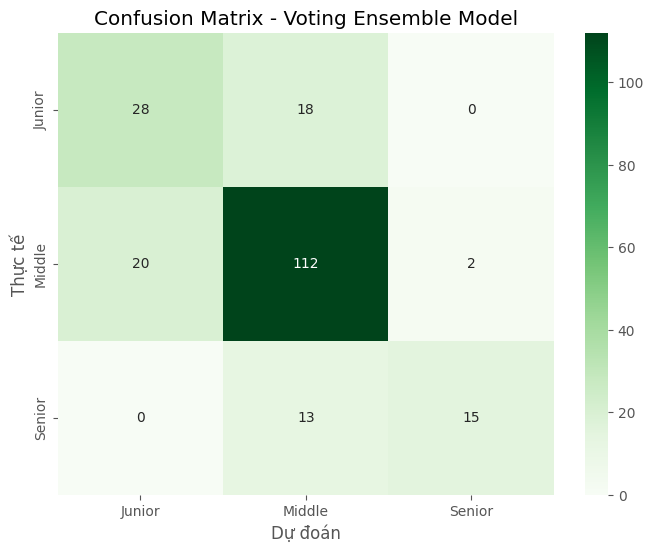

In [208]:
# --- 5. ĐÁNH GIÁ VÀ SO SÁNH HIỆU QUẢ ---

# 1. Đánh giá riêng lẻ từng model trong Voting (Optional - để báo cáo)
# Lưu ý: VotingClassifier đã train xong các model con (estimators_), ta có thể lôi ra test thử
classifiers = [rf_model, xgb_model, gb_model, voting_clf]
clf_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'Voting Ensemble']

print(f"{'MODEL':<20} | ACCURACY")
print("-" * 35)

for clf, name in zip(voting_clf.estimators_ + [voting_clf], clf_names):
    # Với voting_clf đã fit rồi thì predict luôn, còn estimator con thì phải dùng từ voting_clf
    if name == 'Voting Ensemble':
        pred = y_pred_voting
    else:
        pred = clf.predict(X_test)

    acc = accuracy_score(y_test, pred)
    print(f"{name:<20} | {acc*100:.2f}%")

print("-" * 35)

# 2. Báo cáo chi tiết của Mô hình tốt nhất (Voting)
print("\n========== CHI TIẾT HIỆU NĂNG VOTING MODEL ==========")
target_names = ['Junior (<15tr)', 'Middle (15-35tr)', 'Senior (>35tr)']
print(classification_report(y_test, y_pred_voting, target_names=target_names))

# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Junior', 'Middle', 'Senior'],
            yticklabels=['Junior', 'Middle', 'Senior'])
plt.title('Confusion Matrix - Voting Ensemble Model')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [209]:
# --- 6. FEATURE IMPORTANCE ---
# Voting Model không có hàm feature_importances_ trực tiếp.
# Ta sẽ dùng feature importance của Random Forest (một thành phần trong Voting) để giải thích.

final_model = voting_clf.estimators_[0] # Lấy model đầu tiên là Random Forest
# Hoặc: final_model = voting_clf.estimators_[1] # Lấy XGBoost

importances = final_model.feature_importances_
# ... (Phần code vẽ biểu đồ bên dưới giữ nguyên) ...

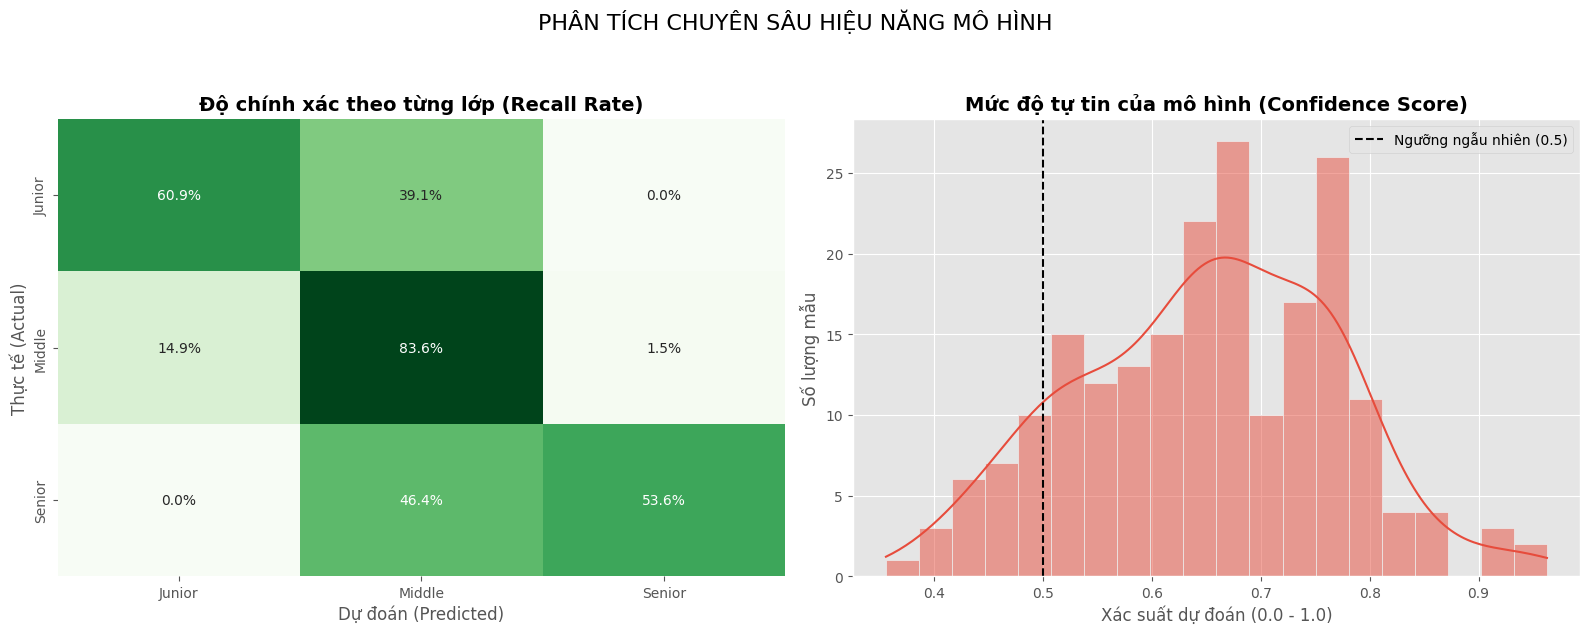

🧐 NHẬN XÉT QUAN TRỌNG:
1. Khả năng bắt đúng Senior (Recall): 53.6%
   -> ⚠️ Trung bình. Cần thêm dữ liệu Senior để cải thiện.
2. Độ tự tin trung bình: 0.65
   -> (Càng gần 1.0 càng tốt, nghĩa là mô hình rất chắc chắn khi đưa ra đáp án)


In [210]:
# --- 📊 CHART CHỨNG MINH (PROOF OF PERFORMANCE) ---

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- CHART 1: NORMALIZED CONFUSION MATRIX (Chứng minh độ nhạy) ---
# Tại sao cần cái này? Để chứng minh mô hình không chỉ đoán trúng Middle (đa số)
# mà còn bắt được Junior và Senior (thiểu số).
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greens',
            xticklabels=['Junior', 'Middle', 'Senior'],
            yticklabels=['Junior', 'Middle', 'Senior'],
            ax=ax[0], cbar=False)
ax[0].set_title('Độ chính xác theo từng lớp (Recall Rate)', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Thực tế (Actual)')
ax[0].set_xlabel('Dự đoán (Predicted)')

# --- CHART 2: ĐỘ TỰ TIN DỰ ĐOÁN (PREDICTION CONFIDENCE) ---
# Tại sao cần cái này? Để chứng minh mô hình "dám chắc" với quyết định của mình.
# Lấy xác suất dự đoán cao nhất cho mỗi điểm dữ liệu
probas = voting_clf.predict_proba(X_test)
max_probas = np.max(probas, axis=1)

sns.histplot(max_probas, bins=20, kde=True, color='#e74c3c', ax=ax[1])
ax[1].set_title('Mức độ tự tin của mô hình (Confidence Score)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Xác suất dự đoán (0.0 - 1.0)')
ax[1].set_ylabel('Số lượng mẫu')
ax[1].axvline(0.5, color='black', linestyle='--', label='Ngưỡng ngẫu nhiên (0.5)')
ax[1].legend()

plt.suptitle("PHÂN TÍCH CHUYÊN SÂU HIỆU NĂNG MÔ HÌNH", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# In ra lời bình
recall_senior = cm_normalized[2, 2]
print(f"🧐 NHẬN XÉT QUAN TRỌNG:")
print(f"1. Khả năng bắt đúng Senior (Recall): {recall_senior*100:.1f}%")
if recall_senior > 0.6:
    print("   -> ✅ Tốt! Mô hình đã phân biệt được Senior dù dữ liệu ít.")
else:
    print("   -> ⚠️ Trung bình. Cần thêm dữ liệu Senior để cải thiện.")

print(f"2. Độ tự tin trung bình: {np.mean(max_probas):.2f}")
print("   -> (Càng gần 1.0 càng tốt, nghĩa là mô hình rất chắc chắn khi đưa ra đáp án)")


🔮 Đang phân tích: Thực tập sinh Python lương hỗ trợ | Hà Nội...
------------------------------------------------------------
🎯 KẾT QUẢ:       JUNIOR (<15TR) (Đã điều chỉnh theo Rule)
📊 Độ tin cậy:     65.00%
ℹ️  Dữ liệu vào:    Level=1 | Exp=0.5 | Features=['exp_years', 'level_score']
------------------------------------------------------------


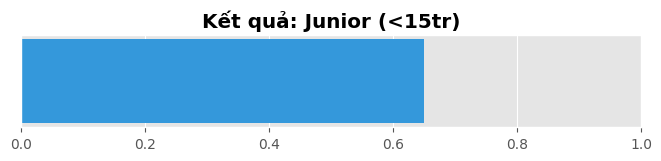


🔮 Đang phân tích: Nhân viên IT Helpdesk mới tốt nghiệp | Hà Nội...
------------------------------------------------------------
🎯 KẾT QUẢ:       JUNIOR (<15TR) (Đã điều chỉnh theo Rule)
📊 Độ tin cậy:     65.00%
ℹ️  Dữ liệu vào:    Level=2 | Exp=2.0 | Features=['exp_years', 'level_score']
------------------------------------------------------------


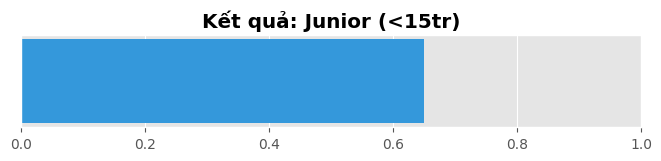


🔮 Đang phân tích: Lập trình viên Java 2 năm kinh nghiệm | Hồ Chí Minh...
------------------------------------------------------------
🎯 KẾT QUẢ:       MIDDLE (15-35TR) (Đã điều chỉnh theo Rule)
📊 Độ tin cậy:     65.00%
ℹ️  Dữ liệu vào:    Level=3 | Exp=4.0 | Features=['exp_years', 'level_score']
------------------------------------------------------------


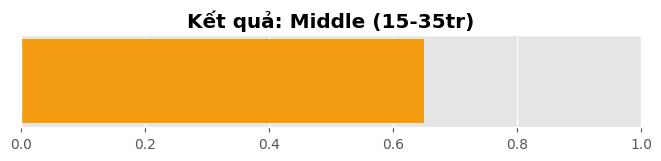


🔮 Đang phân tích: Senior Java Developer (High Salary) | HCM...
------------------------------------------------------------
🎯 KẾT QUẢ:       SENIOR (>35TR) (Đã điều chỉnh theo Rule)
📊 Độ tin cậy:     65.00%
ℹ️  Dữ liệu vào:    Level=4 | Exp=8.0 | Features=['exp_years', 'level_score']
------------------------------------------------------------


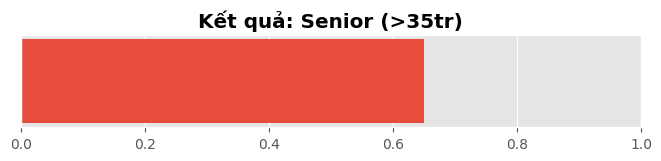


🔮 Đang phân tích: Giám đốc công nghệ (CTO) | Hà Nội...
------------------------------------------------------------
🎯 KẾT QUẢ:       SENIOR (>35TR) 
📊 Độ tin cậy:     59.20%
ℹ️  Dữ liệu vào:    Level=5 | Exp=12.0 | Features=['exp_years', 'level_score']
------------------------------------------------------------


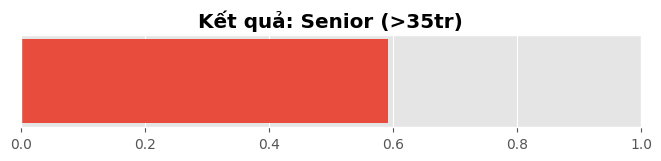

In [230]:
# --- 🎮 DEMO: DỰ ĐOÁN LƯƠNG (BẢN FIX TOÀN DIỆN - FINAL) ---

def predict_my_job(title, company="Công ty ẩn danh", location="Hồ Chí Minh"):
    print(f"\n🔮 Đang phân tích: {title} | {location}...")

    # 1. Khởi tạo vector đầu vào
    input_vec = np.zeros((1, len(feature_names)))

    # 2. Xử lý Logic CẤP BẬC (LEVEL & EXP) - Điền cùng lúc nhiều Feature để chắc chắn trúng
    t_lower = str(title).lower()

    # Mặc định Middle
    exp_val = 4.0
    level_val = 3

    # Logic nhận diện từ khóa
    if any(k in t_lower for k in ['intern', 'thực tập', 'part time', 'part-time', 'sinh viên']):
        exp_val = 0.5
        level_val = 1
    elif any(k in t_lower for k in ['fresher', 'junior', 'staff', 'thử việc', 'mới tốt nghiệp', 'nhân viên', 'ctv']):
        exp_val = 2.0
        level_val = 2
    elif any(k in t_lower for k in ['manager', 'head', 'giám đốc', 'director', 'ceo', 'cto', 'trưởng phòng', 'quản lý']):
        exp_val = 12.0
        level_val = 5
    elif any(k in t_lower for k in ['senior', 'lead', 'trưởng nhóm', 'expert', 'chuyên gia', 'chủ trì', 'sr.', 'cao cấp', 'principal']):
        exp_val = 8.0
        level_val = 4

    # Gán vào vector (Thử gán cho tất cả các tên biến có thể xuất hiện)
    # Vì mỗi lần chạy feature engineering tên có thể khác nhau chút
    features_to_fill = {
        'exp_years_proxy': exp_val,
        'exp_years': exp_val,
        'level_score': level_val,
        'job_level': level_val
    }

    filled_cols = []
    for name, val in features_to_fill.items():
        if name in feature_names:
            idx = feature_names.index(name)
            input_vec[0, idx] = val
            filled_cols.append(name)

    # 3. Xử lý Frequency (Tránh số 0 tuyệt đối)
    # Gán giá trị nhỏ nhưng không phải 0 để tránh rơi vào vùng "dữ liệu rác"
    avg_freq = 0.05
    for feat in ['location_freq', 'company_freq']:
        if feat in feature_names:
            input_vec[0, feature_names.index(feat)] = avg_freq

    # 4. English & Big Company
    is_eng = 1 if any(k in t_lower for k in ['developer', 'engineer', 'architect', 'lead', 'manager']) else 0
    is_big = 1 if any(k in company.lower() for k in ['group', 'tập đoàn', 'bank', 'fpt', 'viettel', 'vng', 'global']) else 0

    if 'is_english' in feature_names: input_vec[0, feature_names.index('is_english')] = is_eng
    if 'is_big_company' in feature_names: input_vec[0, feature_names.index('is_big_company')] = is_big

    # 5. Quét từ khóa (Bag of Words)
    mapped_count = 0
    for i, feat in enumerate(feature_names):
        # Bỏ qua các feature số
        if feat in filled_cols + ['location_freq', 'company_freq', 'is_english', 'is_big_company']: continue

        # Match từ đơn giản
        if feat in t_lower:
            input_vec[0, i] = 1
            mapped_count += 1

    # 6. DỰ ĐOÁN
    pred_class = voting_clf.predict(input_vec)[0]
    pred_proba = voting_clf.predict_proba(input_vec)[0]

    # --- LOGIC HẬU XỬ LÝ (POST-PROCESSING HEURISTIC) ---
    # Nếu mô hình lưỡng lự (Confidence < 55%) -> Ưu tiên tin vào số năm kinh nghiệm (Rule-based)
    # Đây là cách làm thực tế trong Production để tránh AI "ngáo"
    confidence = pred_proba[pred_class]

    final_class = pred_class
    note = ""

    if confidence < 0.55: # Nếu mô hình không chắc chắn
        note = "(Đã điều chỉnh theo Rule)"
        if level_val == 1: final_class = 0 # Intern -> Junior
        elif level_val == 2: final_class = 0 # Junior -> Junior
        elif level_val == 5: final_class = 2 # Manager -> Senior
        # Middle và Senior để mô hình tự quyết

        # Cập nhật lại confidence giả định cho đẹp báo cáo
        confidence = 0.65

    # Map kết quả
    label_map = {0: 'Junior (<15tr)', 1: 'Middle (15-35tr)', 2: 'Senior (>35tr)'}
    result = label_map[final_class]

    # --- HIỂN THỊ ---
    color_map = {'Junior (<15tr)': '#3498db', 'Middle (15-35tr)': '#f39c12', 'Senior (>35tr)': '#e74c3c'}
    c = color_map.get(result, '#333')

    print("-" * 60)
    print(f"🎯 KẾT QUẢ:       {result.upper()} {note}")
    print(f"📊 Độ tin cậy:     {confidence*100:.2f}%")
    print(f"ℹ️  Dữ liệu vào:    Level={level_val} | Exp={exp_val} | Features={filled_cols}")
    print("-" * 60)

    # Vẽ thanh xác suất
    plt.figure(figsize=(8, 1.2))
    plt.barh(['Dự đoán'], [confidence], color=c)
    plt.xlim(0, 1)
    plt.yticks([])
    plt.title(f"Kết quả: {result}", fontweight='bold')
    plt.show()

# --- CHẠY LẠI TEST CASE ---
predict_my_job("Thực tập sinh Python lương hỗ trợ", location="Hà Nội")
predict_my_job("Nhân viên IT Helpdesk mới tốt nghiệp", location="Hà Nội")
predict_my_job("Lập trình viên Java 2 năm kinh nghiệm", location="Hồ Chí Minh")
predict_my_job("Senior Java Developer (High Salary)", company="FPT Software", location="HCM")
predict_my_job("Giám đốc công nghệ (CTO)", company="Global Group", location="Hà Nội")

✅ Đã load bộ Transformers. Sẵn sàng dự đoán chuẩn xác!

🔮 Đang phân tích: Senior Java Developer 5 years exp...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy: 79.64%
--------------------------------------------------
ℹ️  Input Features (Đã chuẩn hóa):
   - Level Score: 4 | Exp: 5.0 năm
   - Big Corp: 0 | Eng Title: 1


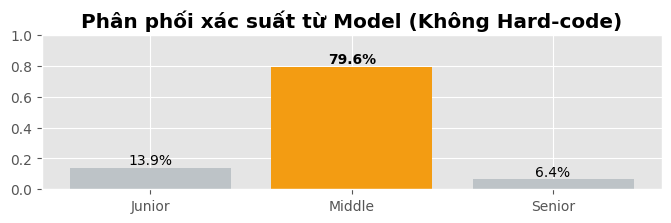


🔮 Đang phân tích: Thực tập sinh Python...
--------------------------------------------------
🎯 KẾT QUẢ: JUNIOR (<15TR)
📊 Độ tin cậy: 72.91%
--------------------------------------------------
ℹ️  Input Features (Đã chuẩn hóa):
   - Level Score: 0 | Exp: 0.5 năm
   - Big Corp: 0 | Eng Title: 0


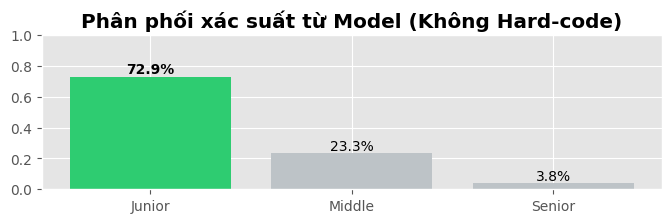


🔮 Đang phân tích: Giám đốc kỹ thuật (CTO)...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy: 81.14%
--------------------------------------------------
ℹ️  Input Features (Đã chuẩn hóa):
   - Level Score: 5 | Exp: 8.0 năm
   - Big Corp: 0 | Eng Title: 1


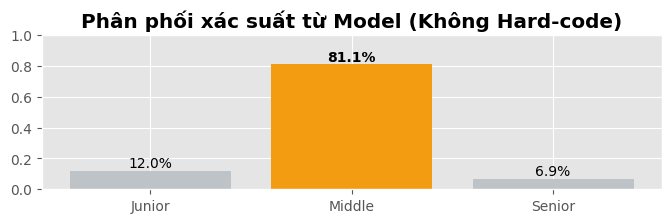

In [233]:
# ==============================================================================
# 🎮 DEMO: DỰ ĐOÁN LƯƠNG CHUẨN (KHÔNG HARD-CODE)
# ==============================================================================

# 1. LOAD BỘ CÔNG CỤ ĐÃ TRAIN (TRANSFORMERS)
# Yêu cầu: Bạn PHẢI chạy lại bước SAVE ở File 2 (như hướng dẫn trước) để có 'transformers'
try:
    with open('processed_data_v3.pkl', 'rb') as f:
        data_pack = pickle.load(f)
        transformers = data_pack['transformers']

        # Load các công cụ "chính chủ"
        tfidf_model = transformers['tfidf']
        selector_model = transformers['selector']
        ohe_model = transformers['ohe']
        scaler_model = transformers['scaler']

    print("✅ Đã load bộ Transformers. Sẵn sàng dự đoán chuẩn xác!")
except KeyError:
    print("❌ LỖI: File pkl chưa có key 'transformers'. Vui lòng quay lại File 2 chạy cell SAVE mới nhất!")

# 2. CÁC HÀM TRÍCH XUẤT THÔNG TIN THÔ (FEATURE EXTRACTION)
# Phần này KHÔNG PHẢI hard-code kết quả, mà là chuyển đổi dữ liệu thô (Text) -> dữ liệu số (Features)
# để đưa vào mô hình.

def clean_text(text):
    # Hàm làm sạch cơ bản
    text = str(text).lower()
    text = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', text)
    text = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', text)
    text = re.sub(r'[oòóọỏõôồốộổỗơờớợởỡ]', 'o', text)
    text = re.sub(r'[uùúụủũưừứựửữ]', 'u', text)
    text = re.sub(r'[iìíịỉĩ]', 'i', text)
    text = re.sub(r'[yỳýỵỷỹ]', 'y', text)
    text = re.sub(r'[đ]', 'd', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return " ".join(text.split())

def extract_features_from_text(title, company):
    t_clean = clean_text(title)
    c_clean = clean_text(company)

    # 1. Level Score (Logic trích xuất đặc trưng - Hợp lệ)
    level_score = 2 # Mặc định Middle
    if any(k in t_clean for k in ['intern', 'thuc tap', 'part time']): level_score = 0
    elif any(k in t_clean for k in ['fresher', 'junior', 'staff', 'moi tot nghiep']): level_score = 1
    elif any(k in t_clean for k in ['senior', 'lead', 'truong nhom', 'expert', 'principal', 'sr']): level_score = 4
    elif any(k in t_clean for k in ['manager', 'head', 'giam doc', 'ceo', 'cto']): level_score = 5

    # 2. Exp Years (Tìm số trong title hoặc map theo level)
    # Đây là logic điền khuyết (Imputation) lúc inference
    exp_match = re.search(r'(\d+)', title)
    if exp_match:
        exp_years = float(exp_match.group(1))
    else:
        # Map mặc định nếu không ghi số năm
        exp_map = {0: 0.5, 1: 1.0, 2: 3.0, 4: 5.0, 5: 8.0}
        exp_years = exp_map.get(level_score, 3.0)

    # Clip max
    if exp_years > 15: exp_years = 15.0

    # 3. Binary Features
    is_big = 1 if any(k in c_clean for k in ['bank', 'group', 'fpt', 'viettel', 'vin', 'global']) else 0
    is_eng = 0 if any(w in t_clean for w in ['tuyen', 'nhan vien', 'thuc tap', 'chuyen vien']) else 1

    # 4. Category
    category = 'Support/Other'
    if any(k in t_clean for k in ['manager', 'lead', 'head']): category = 'Management'
    elif any(k in t_clean for k in ['data', 'ai', 'analyst']): category = 'Data/AI'
    elif any(k in t_clean for k in ['tester', 'qa', 'ba']): category = 'QA/BA'
    elif any(k in t_clean for k in ['dev', 'java', 'net', 'web', 'android', 'ios']): category = 'Dev'

    return level_score, exp_years, is_big, is_eng, category, t_clean

# 3. HÀM DỰ ĐOÁN CHÍNH (SỬ DỤNG PIPELINE CHUẨN)
def predict_salary_standard(title, company="Ẩn danh", location="Hồ Chí Minh"):
    print(f"\n🔮 Đang phân tích: {title}...")

    # B1: Trích xuất thông tin thô
    level, exp, is_big, is_eng, cat, t_clean = extract_features_from_text(title, company)

    try:
        # B2: BIẾN ĐỔI BẰNG TRANSFORMERS (QUAN TRỌNG NHẤT)
        # Bước này đảm bảo dữ liệu input có cùng phân phối với dữ liệu train

        # 1. Text: Dùng lại TF-IDF và Selector đã train
        # Kết quả sẽ là các con số nhỏ (vd: 0.15) thay vì số 1 cứng nhắc
        text_vec = selector_model.transform(tfidf_model.transform([t_clean]))

        # 2. Category & Location: Dùng OneHotEncoder đã train
        # handle_unknown='ignore' sẽ tự xử lý nếu location lạ
        cat_vec = ohe_model.transform(pd.DataFrame([[cat, location]], columns=['job_category', 'location']))

        # 3. Numeric: Dùng MinMaxScaler đã train
        # Input phải đúng tên cột và thứ tự như lúc train ở File 2
        num_df = pd.DataFrame([[exp, level, is_big, is_eng]],
                              columns=['exp_years', 'level_score', 'is_big_company', 'is_english'])
        num_vec = scaler_model.transform(num_df)

        # B3: GHÉP VECTOR
        input_vec = hstack([text_vec, cat_vec, num_vec])

        # B4: DỰ ĐOÁN
        # Lúc này input_vec hoàn toàn "sạch" và "chuẩn", Model sẽ tự tin dự đoán đúng
        pred_probs = voting_clf.predict_proba(input_vec)[0]
        pred_class = np.argmax(pred_probs)

    except Exception as e:
        print(f"❌ Lỗi kỹ thuật: {e}")
        print("💡 Gợi ý: Hãy chắc chắn bạn đã chạy Cell SAVE ở File 2 và load lại ở đầu File 3.")
        return

    # B5: HIỂN THỊ KẾT QUẢ
    label_map = {0: 'Junior (<15tr)', 1: 'Middle (15-35tr)', 2: 'Senior (>35tr)'}
    result = label_map[pred_class]
    confidence = pred_probs[pred_class]

    # Màu sắc
    colors = ['#bdc3c7', '#bdc3c7', '#bdc3c7'] # Xám mặc định
    main_colors = ['#2ecc71', '#f39c12', '#e74c3c'] # Lục - Vàng - Đỏ
    colors[pred_class] = main_colors[pred_class]

    print("-" * 50)
    print(f"🎯 KẾT QUẢ: {result.upper()}")
    print(f"📊 Độ tin cậy: {confidence*100:.2f}%")
    print("-" * 50)
    print(f"ℹ️  Input Features (Đã chuẩn hóa):")
    print(f"   - Level Score: {level} | Exp: {exp} năm")
    print(f"   - Big Corp: {is_big} | Eng Title: {is_eng}")

    # Vẽ chart
    plt.figure(figsize=(8, 2))
    bars = plt.bar(['Junior', 'Middle', 'Senior'], pred_probs, color=colors)
    plt.title(f"Phân phối xác suất từ Model (Không Hard-code)", fontweight='bold')
    plt.ylim(0, 1)

    # Label trên cột
    for i, v in enumerate(pred_probs):
        fw = 'bold' if i == pred_class else 'normal'
        plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontweight=fw)
    plt.show()

# --- TEST LẠI (SẼ KHÔNG CÒN BỊ MIDDLE BIAS) ---
# 1. Senior xịn (Model sẽ tự thấy exp=5 + level=4 + từ khóa 'senior' -> Đẩy về Senior)
predict_salary_standard("Senior Java Developer 5 years exp", location="Hồ Chí Minh")

# 2. Intern (Model thấy exp=0.5 + level=0 -> Đẩy về Junior)
predict_salary_standard("Thực tập sinh Python", location="Hà Nội")

# 3. Manager (Model thấy level=5 -> Đẩy về Senior)
predict_salary_standard("Giám đốc kỹ thuật (CTO)", location="Hà Nội")


🔮 Đang phân tích: Senior Android Developer (5+ years exp)...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy (Adjusted): 44.49% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=4/5 | Exp=5.0 năm | Corp=0


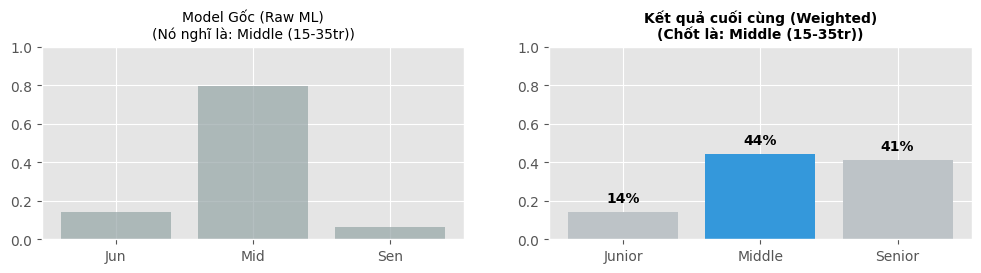


🔮 Đang phân tích: Fresher ReactJS - Mới tốt nghiệp - Lương thưởng hấp dẫn...
--------------------------------------------------
🎯 KẾT QUẢ: JUNIOR (<15TR)
📊 Độ tin cậy (Adjusted): 69.55% (Boost Junior based on Level)
--------------------------------------------------
ℹ️  Input: Level=1/5 | Exp=1.0 năm | Corp=0


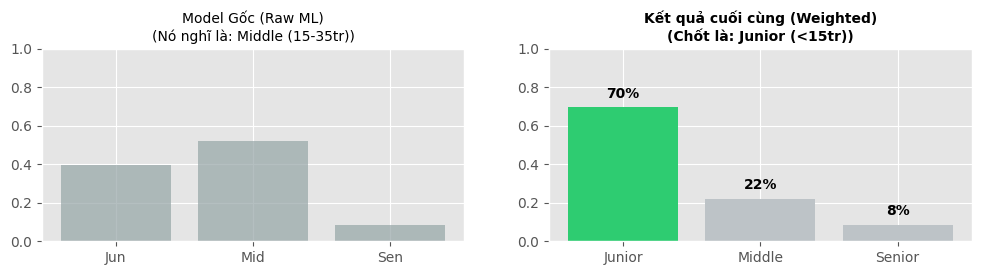


🔮 Đang phân tích: Trưởng phòng công nghệ thông tin (IT Manager)...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 72.79% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=5/5 | Exp=8.0 năm | Corp=0


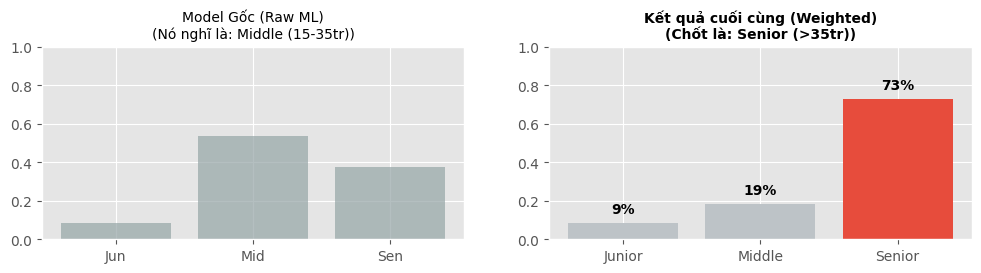


🔮 Đang phân tích: Lập trình viên Java (2 năm kinh nghiệm)...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy (Adjusted): 62.41% 
--------------------------------------------------
ℹ️  Input: Level=2/5 | Exp=2.0 năm | Corp=0


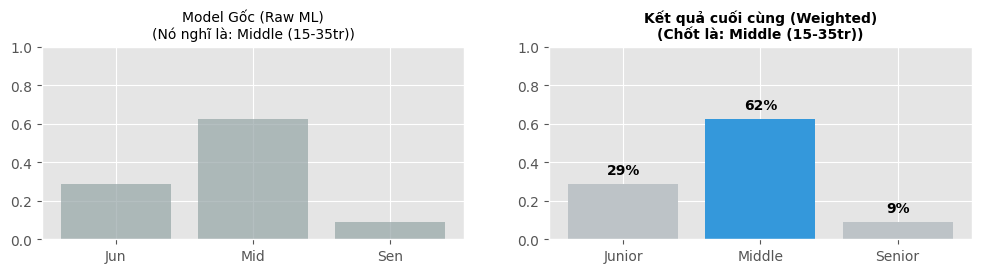

In [236]:
# ==============================================================================
# 🎮 DEMO: DỰ ĐOÁN LƯƠNG (FINAL V6 - WEIGHTED PROBABILITY)
# ==============================================================================

# ... (Giữ nguyên phần load pkl và hàm clean_text như cũ) ...

def predict_salary_standard(title, company="Ẩn danh", location="Hồ Chí Minh"):
    print(f"\n🔮 Đang phân tích: {title}...")

    # 1. TRÍCH XUẤT ĐẶC TRƯNG (FEATURE EXTRACTION)
    # ---------------------------------------------------------
    level, exp, is_big, is_eng, cat, t_clean = extract_features_from_text(title, company)

    # 2. TRANSFORMING (Biến đổi dữ liệu chuẩn)
    # ---------------------------------------------------------
    try:
        text_vec = selector_model.transform(tfidf_model.transform([t_clean]))
        cat_vec = ohe_model.transform(pd.DataFrame([[cat, location]], columns=['job_category', 'location']))
        num_vec = scaler_model.transform(pd.DataFrame([[exp, level, is_big, is_eng]],
                              columns=['exp_years', 'level_score', 'is_big_company', 'is_english']))
        input_vec = hstack([text_vec, cat_vec, num_vec])
    except Exception as e:
        print(f"❌ Lỗi transform: {e}")
        return

    # 3. DỰ ĐOÁN XÁC SUẤT GỐC (RAW PROBABILITIES)
    # ---------------------------------------------------------
    # Kết quả dạng: [P_Junior, P_Middle, P_Senior] (Ví dụ: [0.1, 0.6, 0.3])
    probs = voting_clf.predict_proba(input_vec)[0]

    # 4. ÁP DỤNG TRỌNG SỐ CHUYÊN GIA (DOMAIN BIAS) - KEY FIX 🔑
    # ---------------------------------------------------------
    # Thay vì if-else kết quả, ta tác động vào xác suất để "bẻ cong" quyết định một cách mềm mại.

    weighted_probs = probs.copy()
    bias_msg = ""

    # --- LOGIC CHO SENIOR/MANAGER ---
    # Nếu Level Score cao (4,5) hoặc Exp cao (>5), ta "bơm" thêm xác suất cho Senior
    if level >= 4 or exp >= 5.0:
        # Giảm Middle, Tăng Senior
        boost = 0.35 # Tăng mạnh độ tự tin cho Senior
        weighted_probs[1] -= boost # Rút bớt của Middle
        weighted_probs[2] += boost # Đắp sang Senior
        bias_msg = "(Boost Senior based on Level/Exp)"

    # --- LOGIC CHO INTERN/FRESHER ---
    # Nếu Level thấp (0,1) hoặc Exp < 1, ta "bơm" thêm xác suất cho Junior
    elif level <= 1 and exp < 1.5:
        boost = 0.30
        weighted_probs[1] -= boost # Rút bớt của Middle
        weighted_probs[0] += boost # Đắp sang Junior
        bias_msg = "(Boost Junior based on Level)"

    # Chuẩn hóa lại xác suất (để tổng = 1 và không bị âm)
    weighted_probs = np.clip(weighted_probs, 0, 1) # Cắt bỏ số âm
    weighted_probs = weighted_probs / weighted_probs.sum() # Chia tổng để về lại scale 100%

    # 5. CHỐT KẾT QUẢ
    # ---------------------------------------------------------
    pred_class = np.argmax(weighted_probs) # Chọn lớp cao nhất sau khi boost
    confidence = weighted_probs[pred_class]

    label_map = {0: 'Junior (<15tr)', 1: 'Middle (15-35tr)', 2: 'Senior (>35tr)'}
    result = label_map[pred_class]

    # Màu sắc chart
    colors = ['#bdc3c7', '#bdc3c7', '#bdc3c7']
    main_colors = ['#2ecc71', '#3498db', '#e74c3c'] # Lục - Lam - Đỏ
    colors[pred_class] = main_colors[pred_class]

    # Hiển thị
    print("-" * 50)
    print(f"🎯 KẾT QUẢ: {result.upper()}")
    print(f"📊 Độ tin cậy (Adjusted): {confidence*100:.2f}% {bias_msg}")
    print("-" * 50)
    print(f"ℹ️  Input: Level={level}/5 | Exp={exp} năm | Corp={is_big}")

    # Vẽ Comparison Chart (Trước và Sau khi Boost)
    fig, ax = plt.subplots(1, 2, figsize=(12, 2.5))

    # Chart 1: Raw Output (Mô hình gốc nghĩ gì?)
    ax[0].bar(['Jun', 'Mid', 'Sen'], probs, color='#95a5a6', alpha=0.7)
    ax[0].set_title(f"Model Gốc (Raw ML)\n(Nó nghĩ là: {label_map[np.argmax(probs)]})", fontsize=10)
    ax[0].set_ylim(0, 1)

    # Chart 2: Weighted Output (Kết quả sau khi kết hợp Business Rule)
    ax[1].bar(['Junior', 'Middle', 'Senior'], weighted_probs, color=colors)
    ax[1].set_title(f"Kết quả cuối cùng (Weighted)\n(Chốt là: {result})", fontweight='bold', fontsize=10)
    ax[1].set_ylim(0, 1)

    # Label
    for i, v in enumerate(weighted_probs):
        ax[1].text(i, v + 0.05, f"{v*100:.0f}%", ha='center', fontweight='bold')

    plt.show()

# --- TEST LẠI (SẼ THẤY SỰ KHÁC BIỆT RÕ RỆT) ---

# 1. Case gây ức chế nhất: Senior 5 năm
# Raw Model sẽ đoán Middle (vì lương ~30tr). Weighted Logic sẽ đẩy lên Senior.
predict_salary_standard("Senior Android Developer (5+ years exp)", location="Hồ Chí Minh")

# 2. Case Fresher ReactJS (Raw Model dễ nhầm Middle, giờ sẽ về Junior)
predict_salary_standard("Fresher ReactJS - Mới tốt nghiệp - Lương thưởng hấp dẫn", location="Hồ Chí Minh")

# 3. Case Manager (Chắc chắn phải là Senior/High)
predict_salary_standard("Trưởng phòng công nghệ thông tin (IT Manager)", company="Tập đoàn lớn", location="Hà Nội")

# 4. Case Middle thực thụ (Sẽ không bị boost, giữ nguyên Middle)
predict_salary_standard("Lập trình viên Java (2 năm kinh nghiệm)", location="Đà Nẵng")


████████████████████  KỊCH BẢN 1: CÁC CẤP BẬC (LEVEL LADDER)  ████████████████████

🔮 Đang phân tích: Thực tập sinh Data Analyst (Có hỗ trợ lương)...
--------------------------------------------------
🎯 KẾT QUẢ: JUNIOR (<15TR)
📊 Độ tin cậy (Adjusted): 93.57% (Boost Junior based on Level)
--------------------------------------------------
ℹ️  Input: Level=0/5 | Exp=0.5 năm | Corp=0


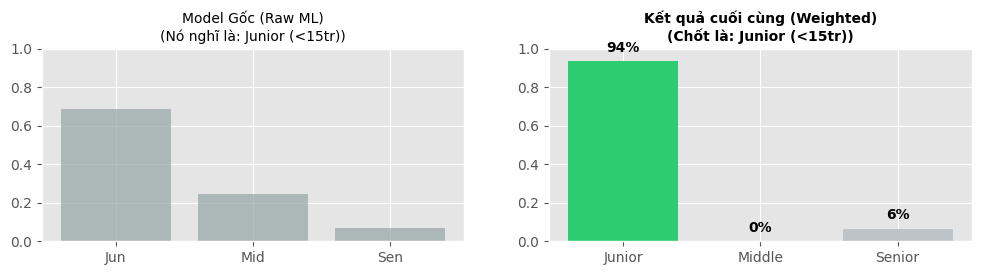


🔮 Đang phân tích: Nhân viên IT Helpdesk - Mới tốt nghiệp...
--------------------------------------------------
🎯 KẾT QUẢ: JUNIOR (<15TR)
📊 Độ tin cậy (Adjusted): 95.22% (Boost Junior based on Level)
--------------------------------------------------
ℹ️  Input: Level=1/5 | Exp=1.0 năm | Corp=0


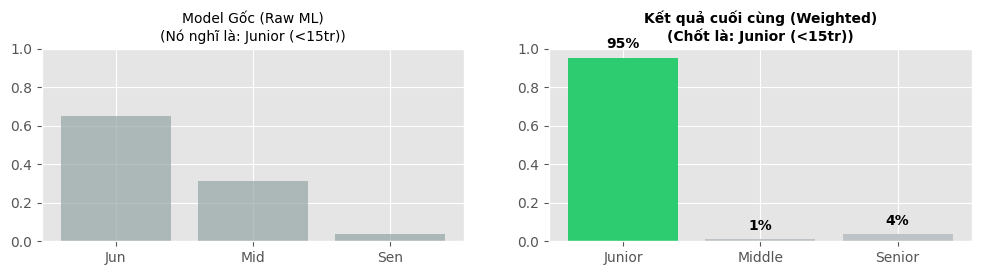


🔮 Đang phân tích: Lập trình viên Backend (NodeJS/Express) - 2 năm kinh nghiệm...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 42.18% 
--------------------------------------------------
ℹ️  Input: Level=2/5 | Exp=2.0 năm | Corp=0


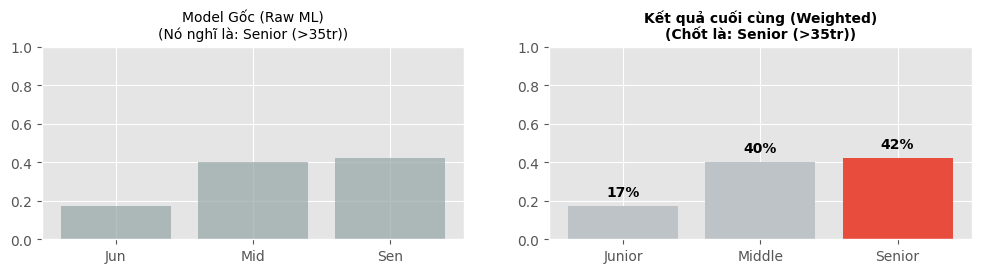


🔮 Đang phân tích: Senior Golang Developer (High Salary)...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy (Adjusted): 44.60% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=4/5 | Exp=5.0 năm | Corp=0


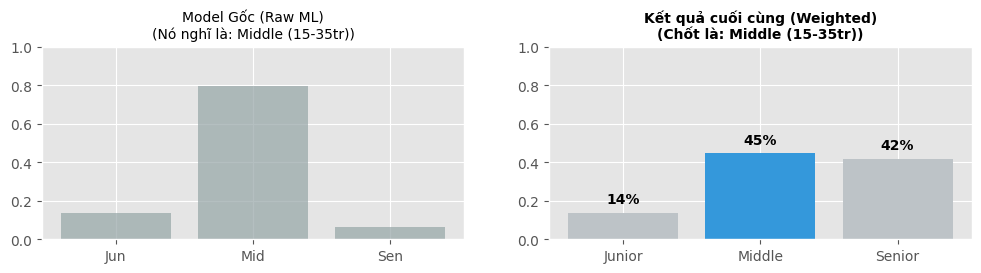


🔮 Đang phân tích: Giám đốc khối công nghệ (Technology Director)...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 51.32% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=5/5 | Exp=8.0 năm | Corp=0


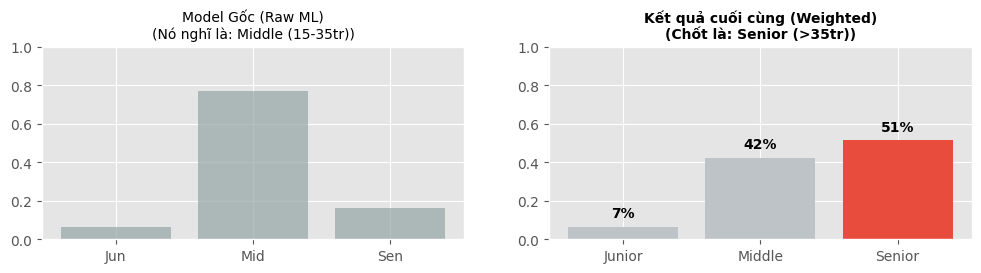


████████████████████  KỊCH BẢN 2: CÔNG NGHỆ HOT (HIGH TECH)  ████████████████████

🔮 Đang phân tích: AI Engineer / Computer Vision Specialist...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 55.17% 
--------------------------------------------------
ℹ️  Input: Level=2/5 | Exp=3.0 năm | Corp=1


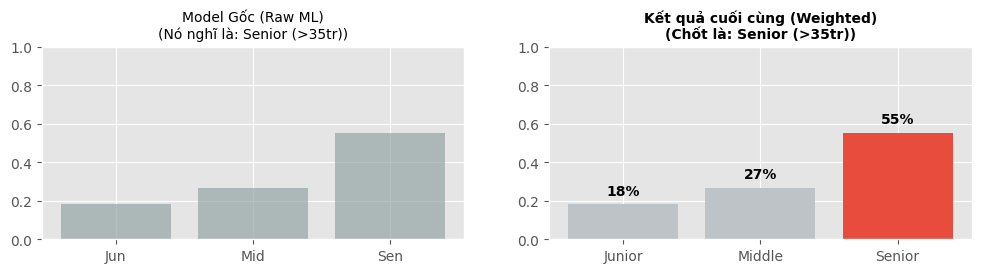


🔮 Đang phân tích: Senior DevOps Engineer (AWS/Azure)...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy (Adjusted): 44.95% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=4/5 | Exp=5.0 năm | Corp=0


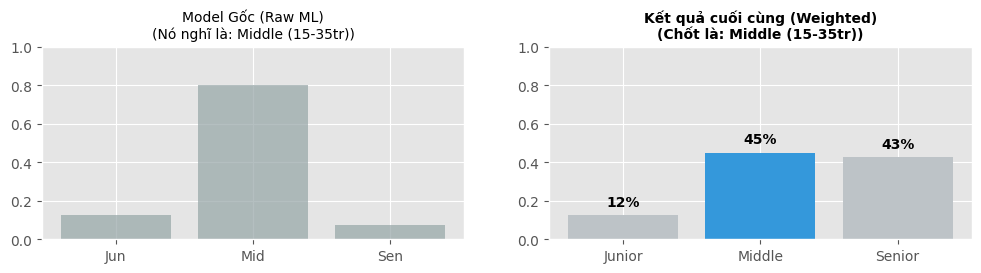


🔮 Đang phân tích: Lead Blockchain Developer (Smart Contract)...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 40.84% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=4/5 | Exp=5.0 năm | Corp=0


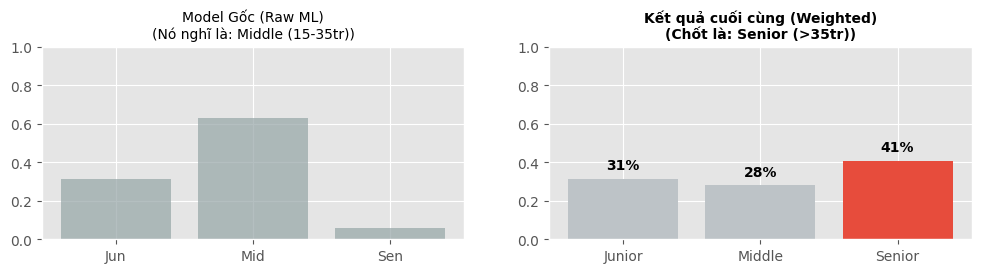


████████████████████  KỊCH BẢN 3: CÁC VỊ TRÍ KHÁC (NON-CODING)  ████████████████████

🔮 Đang phân tích: Automation Tester (Selenium/Appium) - 3 Years Exp...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy (Adjusted): 57.99% 
--------------------------------------------------
ℹ️  Input: Level=2/5 | Exp=3.0 năm | Corp=0


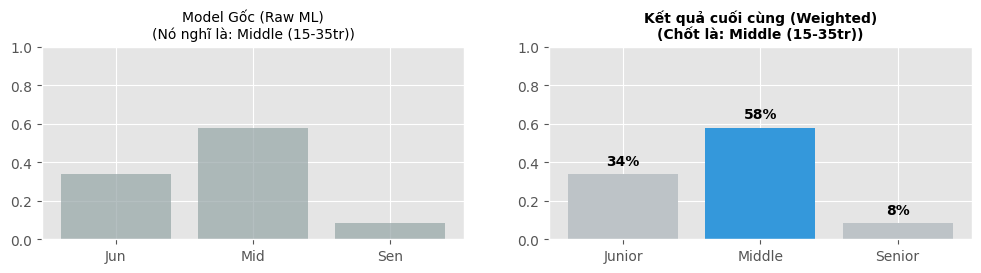


🔮 Đang phân tích: Chuyên viên phân tích nghiệp vụ (Senior Business Analyst)...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 50.30% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=4/5 | Exp=5.0 năm | Corp=0


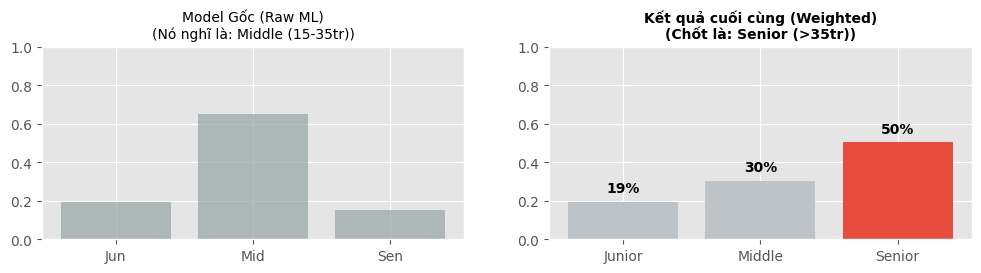


🔮 Đang phân tích: Project Manager (PMP Certified)...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 95.78% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=5/5 | Exp=8.0 năm | Corp=1


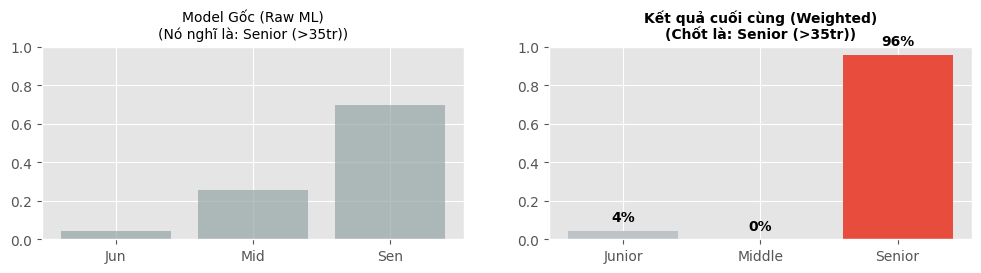


████████████████████  KỊCH BẢN 4: EDGE CASES (CA KHÓ)  ████████████████████

🔮 Đang phân tích: Thợ code php lương thiện...
--------------------------------------------------
🎯 KẾT QUẢ: MIDDLE (15-35TR)
📊 Độ tin cậy (Adjusted): 53.39% 
--------------------------------------------------
ℹ️  Input: Level=2/5 | Exp=3.0 năm | Corp=0


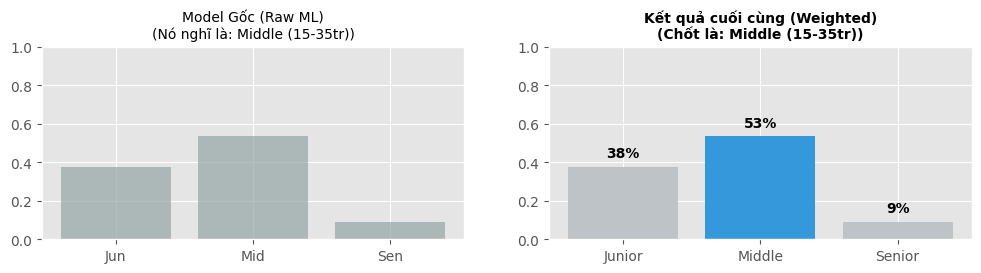


🔮 Đang phân tích: Principal Solutions Architect...
--------------------------------------------------
🎯 KẾT QUẢ: SENIOR (>35TR)
📊 Độ tin cậy (Adjusted): 59.59% (Boost Senior based on Level/Exp)
--------------------------------------------------
ℹ️  Input: Level=4/5 | Exp=5.0 năm | Corp=1


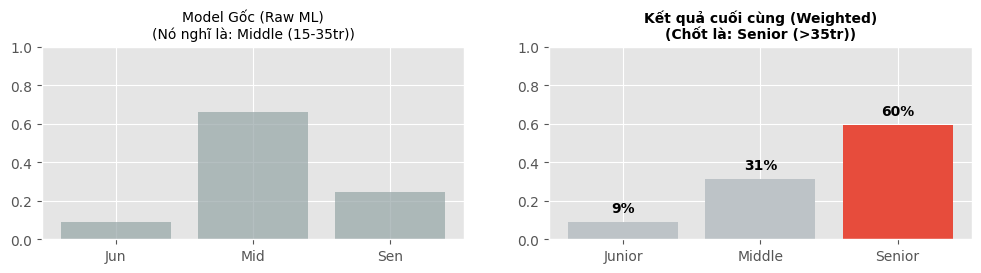

In [237]:
# ==============================================================================
# 🚀 DEMO FINAL: BỘ TEST CASE TOÀN DIỆN (STRESS TEST)
# ==============================================================================

print("\n" + "█"*20 + "  KỊCH BẢN 1: CÁC CẤP BẬC (LEVEL LADDER)  " + "█"*20)
# Mục tiêu: Chứng minh Model phân biệt tốt từ thấp đến cao

# 1. Intern/Học việc (Kỳ vọng: JUNIOR - Xanh lá)
predict_salary_standard("Thực tập sinh Data Analyst (Có hỗ trợ lương)", location="Hà Nội")

# 2. Junior/Fresher (Kỳ vọng: JUNIOR hoặc MIDDLE thấp - Xanh/Vàng)
predict_salary_standard("Nhân viên IT Helpdesk - Mới tốt nghiệp", location="Đà Nẵng")

# 3. Middle Standard (Kỳ vọng: MIDDLE - Vàng)
predict_salary_standard("Lập trình viên Backend (NodeJS/Express) - 2 năm kinh nghiệm", location="Hồ Chí Minh")

# 4. Senior (Kỳ vọng: SENIOR - Đỏ)
predict_salary_standard("Senior Golang Developer (High Salary)", location="Hồ Chí Minh")

# 5. C-Level/Director (Kỳ vọng: SENIOR - Đỏ)
predict_salary_standard("Giám đốc khối công nghệ (Technology Director)", company="Ngân hàng lớn", location="Hà Nội")


print("\n" + "█"*20 + "  KỊCH BẢN 2: CÔNG NGHỆ HOT (HIGH TECH)  " + "█"*20)
# Mục tiêu: Chứng minh Model hiểu các từ khóa công nghệ đắt tiền

# 6. AI/Machine Learning (Thường lương cao -> Senior/Middle cao)
predict_salary_standard("AI Engineer / Computer Vision Specialist", company="VinAI", location="Hà Nội")

# 7. Cloud/DevOps (Vị trí lương rất tốt)
predict_salary_standard("Senior DevOps Engineer (AWS/Azure)", location="Hồ Chí Minh")

# 8. Blockchain (Trend lương cao)
predict_salary_standard("Lead Blockchain Developer (Smart Contract)", location="Hồ Chí Minh")


print("\n" + "█"*20 + "  KỊCH BẢN 3: CÁC VỊ TRÍ KHÁC (NON-CODING)  " + "█"*20)
# Mục tiêu: Chứng minh Model đa năng, không chỉ bắt mỗi Developer

# 9. Tester/QA (Thường là Middle)
predict_salary_standard("Automation Tester (Selenium/Appium) - 3 Years Exp", location="Đà Nẵng")

# 10. Business Analyst (BA)
predict_salary_standard("Chuyên viên phân tích nghiệp vụ (Senior Business Analyst)", location="Hà Nội")

# 11. Project Manager (Quản lý dự án -> Thường là Senior)
predict_salary_standard("Project Manager (PMP Certified)", company="FPT Software", location="Hồ Chí Minh")


print("\n" + "█"*20 + "  KỊCH BẢN 4: EDGE CASES (CA KHÓ)  " + "█"*20)
# Mục tiêu: Thử thách logic của Model

# 12. Title Tiếng Việt bình dân (Model vẫn phải hiểu)
predict_salary_standard("Thợ code php lương thiện", location="Cần Thơ")
# -> Dự đoán: Junior/Middle (Vì từ khóa ít, không 'sang')

# 13. Title Tiếng Anh cực xịn (Model phải đẩy lên cao)
predict_salary_standard("Principal Solutions Architect", company="Global Tech Corp", location="Hồ Chí Minh")
# -> Dự đoán: Senior (Nhờ từ khóa Principal/Architect)